In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
def plots(results_dict, plot_num, trial_num=None):
    S = results_dict['trans_mats']['S']
    Tx = results_dict['trans_mats']['Tx']
    Ty = results_dict['trans_mats']['Ty']
    H = results_dict['trans_mats']['H']
    
    rmse = results_dict['rmse']
    ensemble_array = results_dict['ensemble_array']
    ground_truth = results_dict['ground_truth']
    obs_array = results_dict['obs_array']
    if trial_num is None:
        trial_num = rmse.ptp(axis=1).argmax()
    
    rmse_t = (S @ Tx @ ground_truth[:, trial_num][:, None]
              - S @ Tx @ ensemble_array[:, :, trial_num, :].mean(axis=1))**2
    rmse_t = np.sqrt(rmse_t.mean(axis=0))
    
    state_size = H.shape[1]
    obs_size = H.shape[0]
    assim_num = ensemble_array.shape[-1]
    
    
    t_range = np.arange(
        1, assim_num,
        round(assim_num/(plot_num - 2)))
    t_range = np.concatenate([t_range, [assim_num - 1]])
    x_obs = H @ np.arange(state_size)
    
    this_ensemble = ensemble_array[:, :, trial_num, 0]
    this_rmse = rmse[trial_num, 0]
    this_rmse_t = rmse_t[0]
    
    plt.figure()
    plt.plot(rmse.mean(axis=0))
    plt.ylim([0, None])
    plt.title(f'Average RMSE')
    plt.xlabel('Number of iterations')
    plt.ylabel('RMSE')
    
    plt.figure()
    plt.plot(rmse[trial_num])
    plt.ylim([0, None])
    plt.title(f'RMSE for trial: {trial_num}')
    plt.xlabel('Number of iterations')
    plt.ylabel('RMSE')

    plt.figure()
    plt.plot(rmse_t)
    plt.ylim([0, None])
    plt.title('RMSE in Transformed Space')
    plt.xlabel('Number of iterations')
    plt.ylabel('RMSE')
    
    
    plt.figure()
    plt.plot(ground_truth[:, trial_num], '--')
    plt.plot(
        this_ensemble.mean(axis=1),
        '-')
    plt.legend(['x', 'x ens mean', 'y'])
    plt.title(f'In real space: 0'
              + f'; rmse: {this_rmse:0.5}')
    
    plt.figure()
    plt.plot(S @ Tx @ ground_truth[:, trial_num], '--')
    plt.plot(S @ Tx @ this_ensemble.mean(axis=1), '-')
    plt.legend(['trans truth',
                'trans ens mean', 'trans obs'])
    plt.title(f'In transformed space: 0'
              + f'; rmse: {this_rmse_t:0.5}')
    
    for t in t_range:
        this_ensemble = ensemble_array[:, :, trial_num, t]
        this_obs = obs_array[:, trial_num, t - 1]
        this_rmse = rmse[trial_num, t]
        this_rmse_t = rmse_t[t]
        
        plt.figure()
        plt.plot(ground_truth[:, trial_num], '--')
        plt.plot(this_ensemble.mean(axis=1), '-')        
        plt.scatter(x_obs,
                    this_obs, marker='.')
        plt.legend(['truth', 'ens mean', 'obs'])
        plt.title(f'In real space: {t}'
                  + f'; rmse: {this_rmse:0.5}')
        
        plt.figure()
        plt.plot(S @ Tx @ ground_truth[:, trial_num], '--')
        plt.plot(S @ Tx @ this_ensemble.mean(axis=1), '-')
        plt.scatter(np.arange(obs_size),
                    Ty @ this_obs, marker='.')
        plt.legend(['trans truth',
                    'trans ens mean', 'trans obs'])
        plt.title(
            f'In transformed space: {t}'
            + f'; rmse: {this_rmse_t:0.5}')

In [6]:
dimension = 50
rho0_l = 5
rho0_s = 5
dx = 1
obs_every = 2
H = np.eye(dimension)[::obs_every]
y_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

In [7]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.8
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]


R = np.eye(y_size)

trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  0.9596062325397564
short variance:  0.9596062325397564


Text(0.5,0.98,'Eigenvalues P_s')

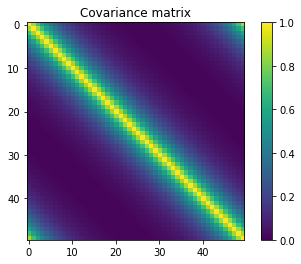

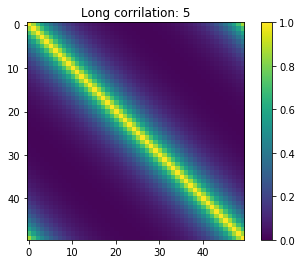

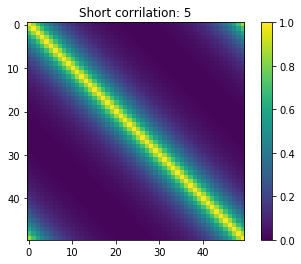

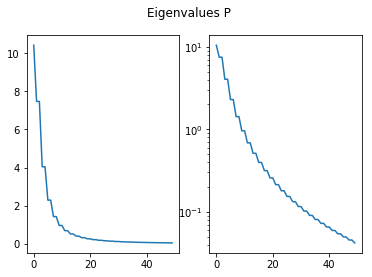

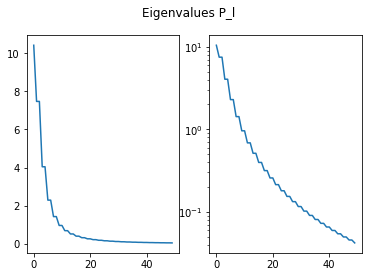

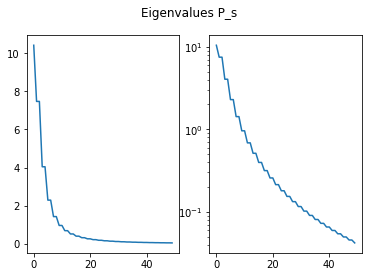

In [8]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

In [14]:
ens_size = int(100)
mu = np.zeros(dimension)

In [15]:
ensemble= (
    assimilate.generate_ensemble(
        ens_size, mu, trans_mats_true['P_sqrt']))

In [16]:
ensemble_trans = Tx @ ensemble

In [23]:
sigma = 5

ensemble_smooth = ndimage.gaussian_filter1d(
    ensemble, sigma=sigma, axis=0, mode='wrap')

# ensemble_smooth = np.repeat(
#     ensemble.mean(axis=0)[None, :],
#     dimension, axis=0)

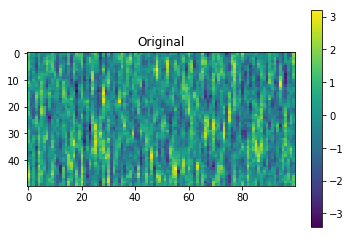

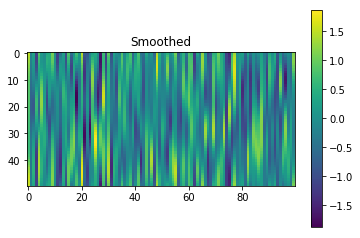

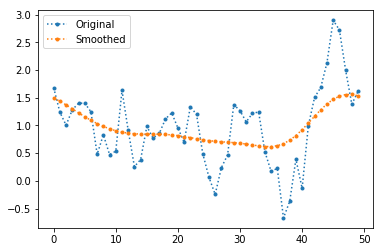

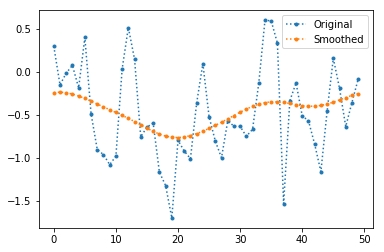

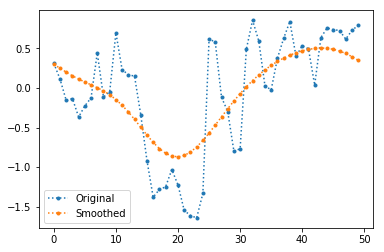

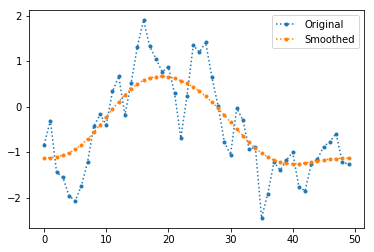

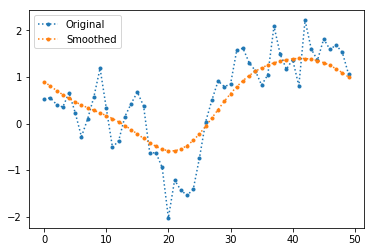

In [24]:
imshow(ensemble, 'Original')
imshow(ensemble_smooth, 'Smoothed')

for ii in range(5):
    plt.figure()
    plt.plot(ensemble[:, ii], ':', marker='.')
    plt.plot(ensemble_smooth[:, ii], ':', marker='.')
    plt.legend(['Original', 'Smoothed'])

In [41]:
P_sample = np.cov(ensemble)
P_smooth = np.cov(ensemble_smooth)
D_sample = np.sqrt(np.diag(P_sample))
D_smooth = np.sqrt(np.diag(P_smooth))

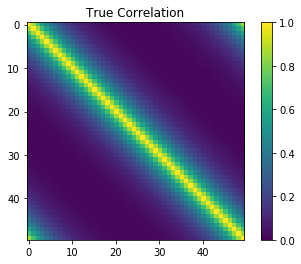

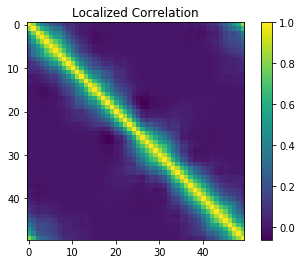

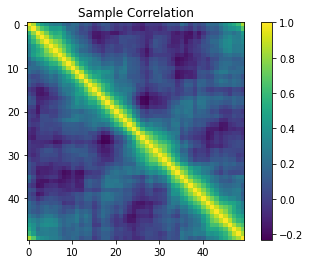

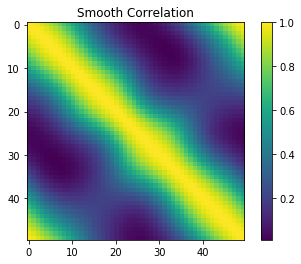

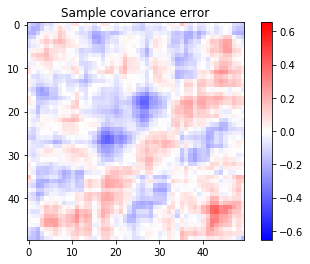

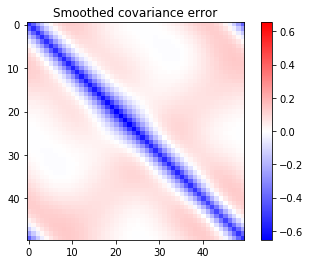

In [43]:
imshow(P, 'True Correlation', vmin=0)

imshow(np.diag(1/D_sample)
       @ P_sample
       @ np.diag(1/D_sample)
       *
       (np.diag(1/D_smooth)
       @ P_smooth
       @ np.diag(1/D_smooth))**2,
       'Localized Correlation')

imshow(np.diag(1/D_sample)
       @ P_sample
       @ np.diag(1/D_sample),
       'Sample Correlation')

imshow(np.diag(1/D_smooth)
       @ P_smooth
       @ np.diag(1/D_smooth),
       'Smooth Correlation')



# imshow(P_smooth,
#        'Sample Covariance smoothed')

# imshow(P_sample,
#        'Sample Covariance',
#        vmin=0, vmax=1)
# imshow(P_smooth,
#        'Sample Covariance smoothed',
#        vmin=0, vmax=1)



error_sample = P_sample - P

error_smooth = P_smooth - P

vmax = np.max([
    np.abs(error_sample).max(),
    np.abs(error_smooth).max()])

imshow(error_sample,
       'Sample covariance error',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_smooth,
       'Smoothed covariance error',
       vmin=-vmax, vmax=vmax, cmap='bwr')

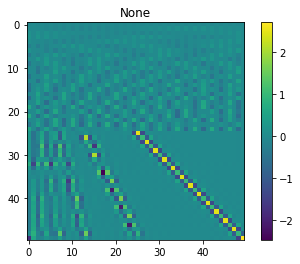

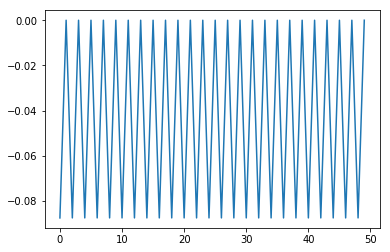

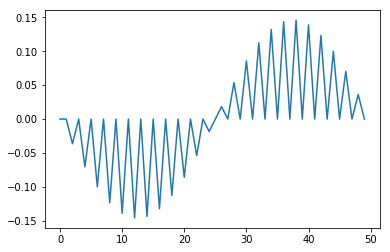

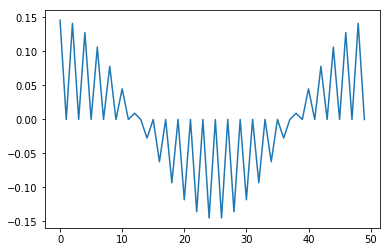

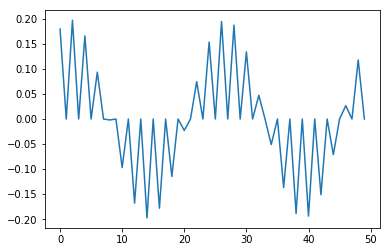

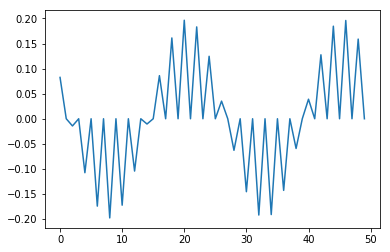

In [40]:
imshow(Tx)
for ii in range(5):
    plt.figure()
    plt.plot(Tx[ii])

In [44]:
eig_val_sample, eig_vec_sample = np.linalg.eigh(P_sample)
eig_val_sample = eig_val_sample[::-1]
eig_vec_sample = eig_vec_sample[:, ::-1]
eig_val_smooth, eig_vec_smooth = np.linalg.eigh(P_smooth)
eig_val_smooth = eig_val_smooth[::-1]
eig_vec_smooth = eig_vec_smooth[:, ::-1]

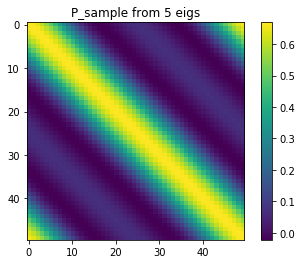

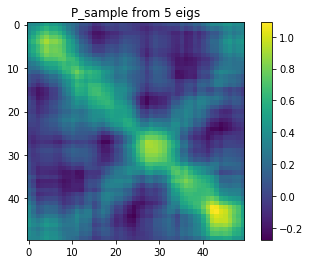

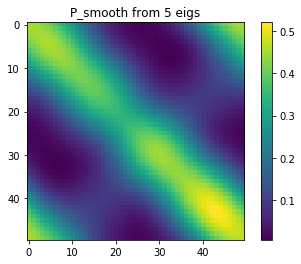

In [46]:
# imshow(eig_vec_sample, 'eig_vec sample')
# imshow(eig_vec_smooth, 'eig_vec smoothed')

# for ii in range(5):
#     plt.figure()
#     plt.plot(eig_vec[:, ii])
#     plt.title(f'eig_vec: {ii}')
    
#     plt.figure()
#     plt.plot(eig_vec_sample[:, ii])
#     plt.title(f'eig_vec_sample: {ii}')
    
#     plt.figure()
#     plt.plot(eig_vec_smooth[:, ii])
#     plt.title(f'eig_vec_smooth: {ii}')

num = 5
imshow(eig_vec[:, :num]
       @ np.diag(eig_val[:num])
       @ eig_vec[:, :num].T, 
       f'P_sample from {num} eigs')

imshow(eig_vec_sample[:, :num]
       @ np.diag(eig_val_sample[:num])
       @ eig_vec_sample[:, :num].T, 
       f'P_sample from {num} eigs')

imshow(eig_vec_smooth[:, :num]
       @ np.diag(eig_val_smooth[:num])
       @ eig_vec_smooth[:, :num].T, 
       f'P_smooth from {num} eigs')

# fig, ax = plt.subplots(1, 2)
# ax[0].plot(eig_val_sample)
# ax[1].semilogy(eig_val_sample)
# ax[0].plot(eig_val)
# ax[1].semilogy(eig_val)
# plt.suptitle('eig_val sample')

# fig, ax = plt.subplots(1, 2)
# ax[0].plot(eig_val_smooth)
# ax[1].semilogy(eig_val_smooth)
# ax[0].plot(eig_val)
# ax[1].semilogy(eig_val)
# plt.suptitle('eig_val smooth')

In [65]:
def calc_transform(ensemble, H,
                   sig_trans,
                   sig_loc,
                   alpha_loc):
    ensemble_trans = ndimage.gaussian_filter1d(
        ensemble, sigma=sig_trans,
        axis=0, mode='wrap')
    ensemble_loc = ndimage.gaussian_filter1d(
        ensemble, sigma=sig_loc,
        axis=0, mode='wrap')
    P = np.cov(ensemble_trans)
    C_loc = np.corrcoef(ensemble_loc)
    D = np.sqrt(np.diag(P))
    C = (np.diag(1/D)
               @ P
               @ np.diag(1/D))
    P = (np.diag(D)
               @ (C * C_loc ** alpha_loc)
               @ np.diag(D))
    eig_val, eig_vec = np.linalg.eigh(P)
    P_sqrt = (eig_vec
              @ np.diag(np.sqrt(eig_val))
              @ eig_vec.T)
    P_inv_sqrt = (eig_vec
                  @ np.diag(
                      1/np.sqrt(eig_val))
                  @ eig_vec.T)
    U, S, VT = sp.linalg.svd(H @ P_sqrt)
    
    Tx = VT @ P_inv_sqrt
    imshow(P)
    imshow(Tx[:10])

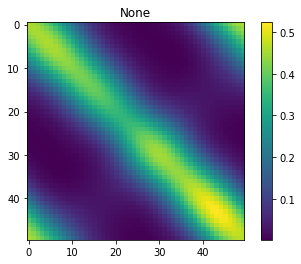

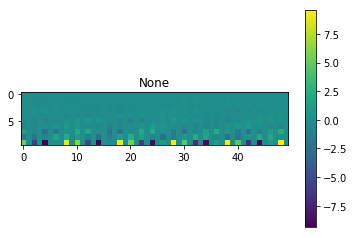

In [66]:
sig_trans = 5
sig_loc = 10
alpha_loc = 2
calc_transform(ensemble, H, sig_trans, sig_loc, alpha_loc)

In [ ]:
eig_val_sample, eig_vec_sample = np.linalg.eigh(P_sample)
eig_val_sample = eig_val_sample[::-1]
eig_vec_sample = eig_vec_sample[:, ::-1]
eig_val_smooth, eig_vec_smooth = np.linalg.eigh(P_smooth)
eig_val_smooth = eig_val_smooth[::-1]
eig_vec_smooth = eig_vec_smooth[:, ::-1]
ensemble_smooth = ndimage.gaussian_filter1d(
    ensemble, sigma=sigma, axis=0, mode='wrap')
P_sample = np.cov(ensemble)
P_smooth = np.cov(ensemble_smooth)
D_sample = np.sqrt(np.diag(P_sample))
D_smooth = np.sqrt(np.diag(P_smooth))

In [ ]:
U_0, S